# Lab Two: Classification
### Laura Ahumada, Kevin Boyd, Shikha Pandey, Duy Nguyen
##### Southern Methodist University
##### Fall, 2022

# Goal: Build upon the previous analysis by adding new classificaiton algorithms, apply appropriate cross validation, and explain which model works the best. 

- ##### We will continue to use our previous income dataset for analysis and modeling


### Libraries

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
import statsmodels.api as sm
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve


from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

from sklearn import metrics as mt
import matplotlib.pyplot as plt
from sklearn.svm import SVC
import os


### Import Data

In [2]:
df = pd.read_csv('adult.csv')

# Data Preparation: Part 1


In [3]:
df.isnull().values.any()

False

In [4]:
df.columns

Index(['age', 'workclass', 'fnlwgt', 'education', 'education.num',
       'marital.status', 'occupation', 'relationship', 'race', 'sex',
       'capital.gain', 'capital.loss', 'hours.per.week', 'native.country',
       'income'],
      dtype='object')

In [5]:
cat_cols = df.select_dtypes(exclude=['int64','int32'])
for i in cat_cols:
    print(cat_cols[i].value_counts().sort_index().index)

Index(['?', 'Federal-gov', 'Local-gov', 'Never-worked', 'Private',
       'Self-emp-inc', 'Self-emp-not-inc', 'State-gov', 'Without-pay'],
      dtype='object')
Index(['10th', '11th', '12th', '1st-4th', '5th-6th', '7th-8th', '9th',
       'Assoc-acdm', 'Assoc-voc', 'Bachelors', 'Doctorate', 'HS-grad',
       'Masters', 'Preschool', 'Prof-school', 'Some-college'],
      dtype='object')
Index(['Divorced', 'Married-AF-spouse', 'Married-civ-spouse',
       'Married-spouse-absent', 'Never-married', 'Separated', 'Widowed'],
      dtype='object')
Index(['?', 'Adm-clerical', 'Armed-Forces', 'Craft-repair', 'Exec-managerial',
       'Farming-fishing', 'Handlers-cleaners', 'Machine-op-inspct',
       'Other-service', 'Priv-house-serv', 'Prof-specialty', 'Protective-serv',
       'Sales', 'Tech-support', 'Transport-moving'],
      dtype='object')
Index(['Husband', 'Not-in-family', 'Other-relative', 'Own-child', 'Unmarried',
       'Wife'],
      dtype='object')
Index(['Amer-Indian-Eskimo', 'Asian

### Things to address:
- ##### Incorrect values "?" values
- ##### Decrease categories in native.countries to immigrants or not (1 or 0)
- ##### Deleting education since it is the same information as education.num
- ##### Encode response variable "income" to 1 or 0
- ##### Encode all categorical variables to 1 or 0, rather than ranked numbers

Despite the "?" values taking around 5% of their respective columns "workclass", "occupation", "native.country", they will not be removed due since it might be due to citizens not wanting to report those 3 things to the government. However, their incomes were still reported among other factors so the missing values will be treated another category "Unknown"

In [6]:
df.isin(['?']).sum(axis=0) * 100 / len(df)

age               0.000000
workclass         5.638647
fnlwgt            0.000000
education         0.000000
education.num     0.000000
marital.status    0.000000
occupation        5.660146
relationship      0.000000
race              0.000000
sex               0.000000
capital.gain      0.000000
capital.loss      0.000000
hours.per.week    0.000000
native.country    1.790486
income            0.000000
dtype: float64

In [7]:
df = df.replace({'?':'Unknown'})

In [8]:
df.isin(['?']).sum(axis=0) * 100 / len(df)

age               0.0
workclass         0.0
fnlwgt            0.0
education         0.0
education.num     0.0
marital.status    0.0
occupation        0.0
relationship      0.0
race              0.0
sex               0.0
capital.gain      0.0
capital.loss      0.0
hours.per.week    0.0
native.country    0.0
income            0.0
dtype: float64

- ##### "Native Country": Replace Non-US with "Immigrant"

In [9]:
# Changing Native Country since the rest of US by country is small that they could all be combined to single to have a greater weight
df['IsImmigrant'] = np.where(df['native.country']!= 'United-States', 1, 0)
del df['native.country']

In [10]:
df.IsImmigrant.value_counts(normalize=True) * 100

0    89.585701
1    10.414299
Name: IsImmigrant, dtype: float64

In [11]:
# Deleting education
del df['education']

- ##### "Income": As 1 and 0 

In [12]:
# Checing the target variable distribution
df.income.value_counts(normalize=True) * 100

<=50K    75.919044
>50K     24.080956
Name: income, dtype: float64

In [13]:
df['income'] = df['income'].map({'<=50K': 0, '>50K': 1}).astype(int) 

In [14]:
df.income.value_counts(normalize=True) * 100

0    75.919044
1    24.080956
Name: income, dtype: float64

- ##### Encoding Categorical Variables 

In [15]:
df.dtypes

age                int64
workclass         object
fnlwgt             int64
education.num      int64
marital.status    object
occupation        object
relationship      object
race              object
sex               object
capital.gain       int64
capital.loss       int64
hours.per.week     int64
income             int64
IsImmigrant        int64
dtype: object

In [16]:
df_continuous = df.select_dtypes(exclude=['object'])
df_discrete = df.select_dtypes(exclude=['int64','int32'])

In [17]:
df_continuous.columns

Index(['age', 'fnlwgt', 'education.num', 'capital.gain', 'capital.loss',
       'hours.per.week', 'income', 'IsImmigrant'],
      dtype='object')

In [18]:
df_discrete.columns

Index(['workclass', 'marital.status', 'occupation', 'relationship', 'race',
       'sex'],
      dtype='object')

In [19]:
df=pd.get_dummies(df, columns=df_discrete.columns)

In [20]:
df.head()

,age,fnlwgt,education.num,capital.gain,capital.loss,hours.per.week,income,IsImmigrant,workclass_Federal-gov,workclass_Local-gov,...,relationship_Own-child,relationship_Unmarried,relationship_Wife,race_Amer-Indian-Eskimo,race_Asian-Pac-Islander,race_Black,race_Other,race_White,sex_Female,sex_Male
0,90,77053,9,0,4356,40,0,0,0,0,...,0,0,0,0,0,0,0,1,1,0
1,82,132870,9,0,4356,18,0,0,0,0,...,0,0,0,0,0,0,0,1,1,0
2,66,186061,10,0,4356,40,0,0,0,0,...,0,1,0,0,0,1,0,0,1,0
3,54,140359,4,0,3900,40,0,0,0,0,...,0,1,0,0,0,0,0,1,1,0
4,41,264663,10,0,3900,40,0,0,0,0,...,1,0,0,0,0,0,0,1,1,0


- ##### Separate Features from Response (Prep for Models)

In [21]:
x = df.drop("income", axis = 1)

In [22]:
y = df["income"] # this returns a dataframe, better suited for model functions
                   # rather than df["income"]

- ##### Scaling the Data 

We are not going to transform our categorical(dummies) as they loose their interpretation. If we standardized them, we would be treating them as quantitative variables which does not interpret correctly.

In [23]:
# Standarizing variables excluding the categories(dummies)
for i in (df_continuous.columns):
    if (i !="income" and i!="IsImmigrant"):
        x[i] = StandardScaler().fit_transform(x[[i]])

### Dimension Reduction with PCA
- ##### Kaiser Rule: the goal is to seek number of PCs that have eigenvalues >= 1, hence the dotted red line below
- We know that there is no multicolinearity and that most of the variables are categorical so we are not sure if PCA will be helpful but testing it out.

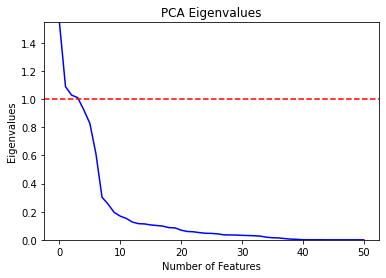

4 feature(s) are enough to describe the data.


In [24]:
pca = PCA(n_components=None) # initially set n_components to "None" to include all 67 features
pca.fit(x)

plt.ylabel('Eigenvalues')
plt.xlabel('Number of Features')
plt.title('PCA Eigenvalues')
plt.ylim(0, max(pca.explained_variance_))
plt.plot(pca.explained_variance_, color='b')
plt.axhline(y=1, color='r', linestyle='--')
plt.show()

# display the actual eigenvalues
count = 0
for i in pca.explained_variance_ :
    if i > 1 :                       # eigenvalues >= 1
        count = count + 1
print(count, 'feature(s) are enough to describe the data.')

- ##### Cumulative Variance Explained: the selected PCs should describe atleast 80% of the data, hence the dotted red line below

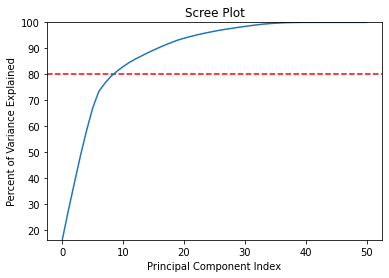

42 principal components(s) describe atleast 80% of the data.


In [25]:
variance = pca.explained_variance_ratio_ * 100
cumu_variance = np.cumsum(variance)

plt.ylabel('Percent of Variance Explained')
plt.xlabel('Principal Component Index')
plt.title('Scree Plot')
plt.ylim(min(cumu_variance), 100)
plt.axhline(y=80, color='r', linestyle='--')
plt.plot(cumu_variance)
plt.show()

cumu_variance
# display the actual eigenvalues
count = 0
for i in cumu_variance :
    if i > 80 :                       # eigenvalues >= 1
        count = count + 1
print(count, 'principal components(s) describe atleast 80% of the data.')

# Data Preparation: Part 2


The data consists of 32,561 entries/rows and 13 attributes/columns, with the response variable being "income".

Out of the 13 variables, 6 are continuous and 7 are categorical. The only new variable that was created is "IsImmigrant" which was set because of the discrepancy between US as native.country and the rest of the countries having such tiny percentage. We thought having is immigrant could explain better/have a larger representation due to the results of the data. In exchange we dropped native.country when the new attribute was created. 

Per EDA this data is not suited well for PCA.

Continuous variables: age, fnlwgt, education.num, capital.gain, capital.loss, hours.per.week, IsImmigrant

Categorical Variables: Workclass,marital.status, occupation, relationship, race, sex, 


In order to begin prep for the models the continuous attributes have been standarized and the categorical variables have been converted into one hot encoding.

Our goal with this final dataset is to classify whether if people have greater than $50k income or not, which includes 1 response variable and 67 predictor variables. Out of those 67, 6 are unchanged as they are originally continuous, 1 was originally "native.country" which was modify to "IsImmigrant" (with "United States" as "0" and others as "1"), and the rest 60 are one-hot encoded as dummies.

PCA is not an appropriate pre-processing method for our data, since we have too many PCs that efficiently describes our data.

# Modeling and Evaluation: Part 1


When considering Precision, Accuracy, Recall, and the F-measure, the most useful for our task is Precision. We will focus on Precision becasuse our main goal is to get an accurate sample of those people that earn >50K to further analyze which factors contribute most to that outcome. Furthermore, we would like to see if there are any societal gaps that need to be looked at more closely that are keeping people from making 50K. Some factors are not within a persons' ability to change, but it is important to learn which factors that influence income a person can actually change. This is why we care most about the factors that predict a person making >50K, and that they really do influence a person making >50k (how many positive predicitions really are positive). 

While we do care more about precision, an example of why recall could be important can be applied to different groups providing financial aid. There is only a certain amount of total financial aid that a group can distribute amung students and it is important that the money is going to people that truly need it (true negatives: predicted to NOT make >50K and actually do makes <=50K). For this purpose, we would want a classification threshold to both balance a highly accurate true positive and low on false negatives (make >50k but were classified as making <=50), so that the financial aid groups can target pepole that actually need the help.

We also need to take into account that 75% of our dataset are stated to make <=50K and only 25% make >50K. It is important that we modify the threshold to represent our unequal number of responses. A 50% threshold wouldn't represent the data correctly. ROC takes advantage of this threshold being appropriately represented and will also be used to compare the models.

# Modeling and Evaluation: Part 2


We will be using Stratified validation because we want to be able to split the variables randomly and equally among the testing and trainig data. For instance, if we don't use stratified the train data may obtain only 5% of the data with >50K which then ends up leading to a model that is not able to predict as well since it has so little information on those with >50K. We want the distribtuion of those with >50K and as well as those with <=50K to be equally representative in training and testing.

- ##### Splitting the Data

In [26]:
#splitting data
X_train_scaled, X_test_scaled, y_train, y_test = train_test_split(x, y, stratify=y,test_size=.30, random_state=1)

# Modeling and Evaluation: Part 3



- Model 1: Logistic Regression
- Model 2: SVM
- Model 3: Decision Tree Classifier
- Model 4: Random Forest
- Model 5: Naive-Bayes Bernoulli
- Mdeol 6: KNN Cosine

# Logistic Regression

+ We tried adding class_weight="balanced" and all the scores decreased so we didn't adjust the weights or support.
+ The simple model did lead to almost the same results as with cross validation. However, we kept as stratify each set contains approximately the same percentage of samples of each target class.

In [27]:
# Function to get the metrics
def score_rep (model, y_hat,threashHold=0.7,svm="no",show="yes"):
        if svm=="yes":
            preds=svm_clf.decision_function(X_test_scaled)>threashHold
            prob_df=pd.DataFrame({"prediProb":svm_clf.decision_function(X_test_scaled), "pred": preds, "actual":y_test})
        else:
            preds = np.where(model.predict_proba(X_test_scaled)[:,1] > threashHold, 1, 0)
            prob_df=pd.DataFrame({"prediProb":model.predict_proba(X_test_scaled)[:,1], "pred": preds, "actual":y_test})
        fp=prob_df[(prob_df["actual"]==0) & (prob_df["pred"]==1)].shape[0]
        tp=prob_df[(prob_df["actual"]==1) & (prob_df["pred"]==1)].shape[0]
        fn=prob_df[(prob_df["actual"]==1) & (prob_df["pred"]==0)].shape[0]
        tn=prob_df[(prob_df["actual"]==0) & (prob_df["pred"]==0)].shape[0]
       
        prec=round((tp/(fp+tp)),3)
        rec=round((tp/(tp+fn)),3)
        acc=round(((tp+tn)/(tp+fp+fn+tn)),3)
        f1= round((mt.f1_score(y_test,preds)),3)
        auc=round((mt.roc_auc_score(y_test,y_hat)),3)
        if show!="no":
            print('Accuracy is: %.2f, Recall is: %.2f, Precision is: %.2f, F1 is %.2f and AUC is %.2f'% (acc,rec,prec,f1,auc))
        return(acc,rec,prec,f1,auc)  

In [28]:
# Import libraries
from sklearn.model_selection import ShuffleSplit
from sklearn.linear_model import LogisticRegression
from sklearn import metrics as mt
from sklearn.model_selection import cross_validate
from sklearn.model_selection import StratifiedKFold, cross_val_score

#to save results of all models
model_results=[]

In [29]:
#running model
# Per earlier mini project we know these are the best arguments
lr_clf = LogisticRegression(penalty='l2', C=1.0, class_weight=None, solver='liblinear' )

# Running stratified kfold  cross validation with a threshold of 0.5
scoring = ['precision_macro', 'recall_macro']
sk_folds = StratifiedKFold(n_splits = 10)
scores = cross_validate(lr_clf, x, y, scoring=scoring, cv = sk_folds)

print("Average recall CV Score: ", np.mean(scores['test_recall_macro']))
print("Average precision CV Score: ", np.mean(scores['test_precision_macro']))

Average recall CV Score:  0.7469703013541078
Average precision CV Score:  0.7993594250942933


In [30]:
# Logist Regression with threshold of 0.7

lr=lr_clf.fit(X_train_scaled,y_train)
y_hat=lr.predict(X_test_scaled)
  
acc, rec,prec,f1,auc=score_rep(lr,y_hat)
model_results=[["Logistic Regression",acc, rec,prec,f1,auc]]       


Accuracy is: 0.84, Recall is: 0.39, Precision is: 0.87, F1 is 0.54 and AUC is 0.77


- # Interpreting Weights


##### The most important variables per Logistic Regression 
    Capital gain 
    Education num
    Marital status 
    Age
    Hours per Week
    
+ This graph also shows how every variable has some importance and thus all are useful and have an impact on income.
+ Capital Gain, not surprisingly, shows highest weight as it did contain large numerical values in the data. It would also have practical sense because people with higher income would be able to have more savings.
+ Education num with second highest weight is another variable that makes sense to have higher impact on income because traditionally in society people with higher education have higher paying jobs and hance higher income.
+ Marital Status is the third higest impacting variable in the model which would concur with the socio-economic structure in society. Married households could impact an individual's income in various ways, one of which would be sharing expenses.
+ Age is next important variable in our model which is completely practical because people within age range of 20-60 have higher income potential because before 20, most would be in school and after 60, most would retire.
+ Hours per Week is the last important variable per our model and understandably so - generally, a person with more working hours would make more income that the one with less working hours.

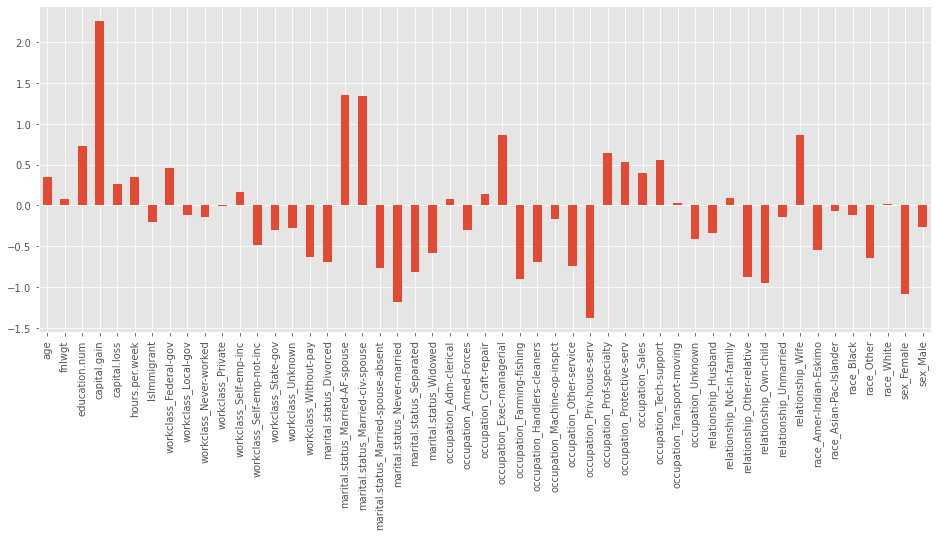

In [31]:
# Plot
from matplotlib import pyplot as plt
%matplotlib inline
plt.figure(figsize=(16,6))
plt.style.use('ggplot')

weights = pd.Series(lr.coef_[0],index=x.columns)
weights.plot(kind='bar')
plt.show()

#### The precision obtained for Logistic Regression was 87% with a threshold of 0.7. The AUC was 77%. While this model does appear to perform very well we will continue to look into other models.

# SVM

+ We tried different values for C and the best one we found was 0.5
+ We also used the option rbf (radial basis function kernel) which is similar to KNN but is able to deal with the high dimensional space seen in our data. The support vector machines just need to create and store the support vectors during the training but not the entire dataset. 
+ Using the ROC plot we see that SVM is perfoming very well. It looks very similar to logistic regression with a slightly lower AUC of 0.75 compared to logistic regression with an AUC of 0.76.
+ SVM is a computationally intensive model so it does take a while to run.
+ We have included a fair number of explanitory variable which is going to make the interpretaion more difficult in the mulitdemensional space.

In [32]:
# Doing cross val only to verify restults
# Using only train Data other wise it will see the test data and there would be data leakage

from sklearn.model_selection import cross_validate
from sklearn.model_selection import StratifiedKFold, cross_val_score

# Running SVM
from sklearn.svm import SVC

# train the model just as before
svm_clf = SVC(C=0.5, kernel='rbf', degree=3, gamma='auto') # get object

scoring = ['precision_macro', 'recall_macro']
sk_folds = StratifiedKFold(n_splits = 5)
scores = cross_validate(svm_clf, x, y, scoring=scoring, cv = sk_folds)

print("Average recall CV Score: ", np.mean(scores['test_recall_macro']))
print("Average precision CV Score: ", np.mean(scores['test_precision_macro']))


Average recall CV Score:  0.7021822260805787
Average precision CV Score:  0.7902992710247798


In [33]:
svm_clf=svm_clf.fit(X_train_scaled, y_train)  # train object

y_hat = svm_clf.predict(X_test_scaled) # get test set predictions

# Get all scores  
acc, rec,prec,f1,auc=score_rep(svm_clf,y_hat,svm="yes")
# Append to list of all scores
model_results.append(["SVM",acc, rec,prec,f1,auc])

Accuracy is: 0.84, Recall is: 0.37, Precision is: 0.88, F1 is 0.52 and AUC is 0.75


#### We can see that with this model we have a precision of 88%, increasing 1 point from logistic regression, with a threshold of 0.7. The AUC was a bit lower at 75%. We do desire to have a high precision but it is possible another model will perform better than this SVM model.

# Decision Tree

+ For decision tree we can see that it picked up Married CIV spouse as the most important feature followed by capital.gain and education.num. These are some of the features that were also picked by the other models. It is still interesting to see that Married CIV specifically is picked but that could because married in a non military family means stability and support.

+ Decision trees are very good when it comes to being able to interpret them and how the features are selected. In this case we know we have to set some criterias for the model to not overfit, so we selected criterion gini and max depth of 3.


In [34]:
from sklearn.tree import DecisionTreeClassifier
dTreeR = DecisionTreeClassifier(criterion = 'gini', max_depth = 3, random_state=1)
dTreeR=dTreeR.fit(X_train_scaled, y_train)
y_hat=dTreeR.predict(X_test_scaled)
# run function to get accuracy, recall and precision
acc, rec,prec,f1,auc=score_rep(dTreeR,y_hat)
# Append to list of results
model_results.append(["Decision Classifier",acc, rec,prec,f1,auc])
print('')
print("Having the training and test score very close means that it was a good model and did not overfit.")
print("Training score",dTreeR.score(X_train_scaled, y_train))
print("Testing score",dTreeR.score(X_test_scaled, y_test))


Accuracy is: 0.81, Recall is: 0.20, Precision is: 0.99, F1 is 0.34 and AUC is 0.73

Having the training and test score very close means that it was a good model and did not overfit.
Training score 0.8434977184977185
Testing score 0.8448152318558706


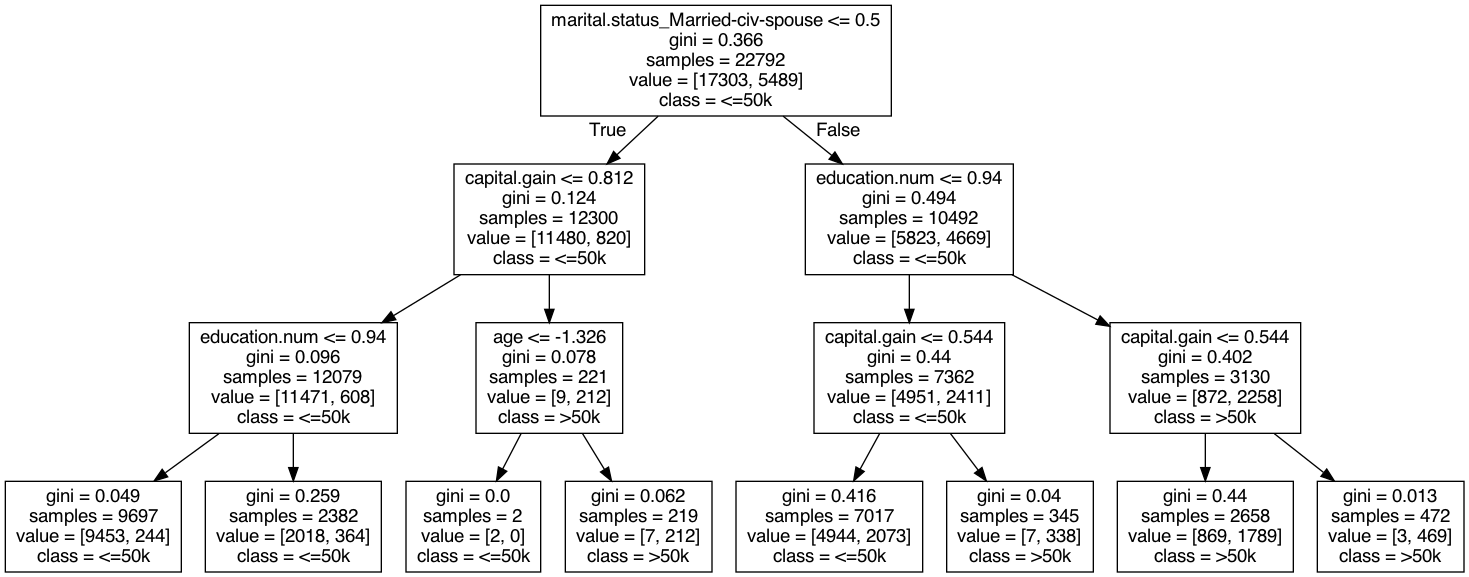

In [35]:
from IPython.display import Image  
#import pydotplus as pydot
from sklearn import tree
from os import system
train_char_label = ["<=50k", ">50k"]
Credit_Tree_FileR = open('credit_treeR.dot','w')
dot_data = tree.export_graphviz(dTreeR, out_file=Credit_Tree_FileR, feature_names = list(X_train_scaled), class_names = list(train_char_label))
Credit_Tree_FileR.close()

retCode = system("dot -Tpng credit_treeR.dot -o credit_treeR.png")
if(retCode>0):
    print("system command returning error: "+str(retCode))
else:
    display(Image("credit_treeR.png"))



#### This model has the best precision of 99% having a threshold of 0.7. Of course this means that recall took a hit being at 20%. Interestingly, the AUC is not as high, even lower than SVM at 73%. Let's see if Random Forest will do as good in precision without making recall this low and having a better AUC.

# Ensemble RandomForest Classifier

+ We can see that Random Forest selected fnlwgt as one of the top important features along with age, education.num, caital.gain and marrital status.
+ Random Forest gets power from the multiple decision trees that are ensembled together.
+ We can see from the plot below that some explanatory variables are much more important in our model. This advantage is very helpful for understanding the factors that are contributing to our predictions.

In [36]:
from sklearn.ensemble import RandomForestClassifier
rfcl = RandomForestClassifier(n_estimators = 50, random_state=1,max_features=12)
rfcl = rfcl.fit(X_train_scaled, y_train)
y_predict = rfcl.predict(X_test_scaled)
#Get all scores
acc, rec,prec,f1,auc=score_rep(rfcl,y_predict)
# Append to list of scores
model_results.append(["Random Forest",acc, rec,prec,f1,auc])

Accuracy is: 0.85, Recall is: 0.46, Precision is: 0.87, F1 is 0.60 and AUC is 0.78


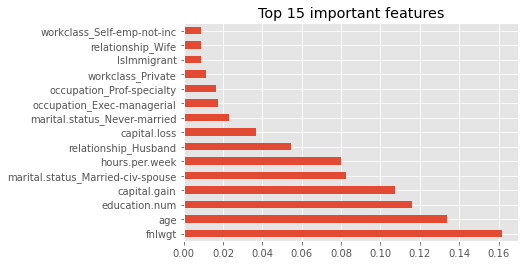

In [37]:
feat_importances = pd.Series(rfcl.feature_importances_, index=x.columns)
feat_importances.nlargest(15).plot(kind='barh')
plt.title("Top 15 important features")
plt.show()

+ It is interesting to see that fnlwgt was the top feature which did not appear as significant in logistic regression nor decision trees. However, it makes sense that it would be an important variable because fnlwgt has an almost equal distribution within the target classes of <=50k and >50k income.

+ On the other hand, age, education.num and capital.gain were some of the top features in the other models as well which was consistant. These 3 features makes intuitive sense to have an impact on how much one will earn because regardless of the job, someone that is older and has more experience will have a higher income, just like education. Also many people in our dataset report 0 capital gains but the ones that do report capital gains will have a boost on their income. 

+ Interestingly, self employed is one of the top 15 important features.
+ relationship_Husband is the 7th top feature which is interesting because it's way higher in list than relationship_Wife which goes to say how men do show to have higher income than women as seen on the EDA.


#### The precision was not as good as decision tree with 87%, however recall was more than doubled from decision tree with 46% with a threshold of 0.7. The AUC was the best so far at 78%.

# Naive Bayes

+ While there is some concern about independence between expalnatory variables, it is impossible to make sure that there is complete independence in the real world so we will still move forward with this model.
+ After testing multiple binarize values and different values for alpha the best naive bayes model was a bernoulli with alpha 0.5 and binarize of 0.07.
+ This makes logical sense since is our target is descrete and binary.

In [38]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import BernoulliNB

# Running model with different parameters

alpha_list=[0.1,0.5,0.7,1.0,5]
binarize_list=[0.0,0.05,0.07,0.09,2]
multi_result=[]
bernou_result=[]

for i in (alpha_list):
    for j in (binarize_list):
        clf_bnb = BernoulliNB(alpha=i, binarize=j)
        bern=clf_bnb.fit(X_train_scaled, y_train)
        y_hat=bern.predict(X_test_scaled)
        rec = mt.recall_score(y_test,y_hat)
        bernou_result.append(rec)
        
print("The best Bernoulli recall was %.2f"%(max(bernou_result)))


The best Bernoulli recall was 0.79


In [39]:
# Run again and best parameters
clf_bnb = BernoulliNB(alpha=0.5, binarize=0.07)
bern=clf_bnb.fit(X_train_scaled, y_train)
y_hat=bern.predict(X_test_scaled)
acc, rec,prec,f1,auc=score_rep(bern,y_hat)
model_results.append(["NaiveBayes Bernoulli",acc, rec,prec,f1,auc])

Accuracy is: 0.78, Recall is: 0.74, Precision is: 0.53, F1 is 0.62 and AUC is 0.77


<AxesSubplot:>

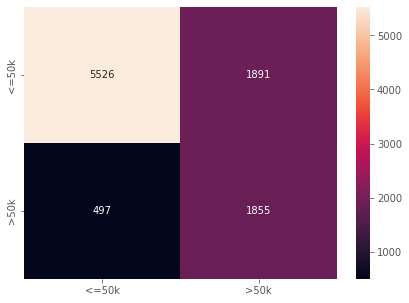

In [40]:
from sklearn import metrics
bern=clf_bnb.fit(X_train_scaled, y_train)
y_hat=bern.predict(X_test_scaled)
cm=metrics.confusion_matrix(y_test, y_hat,labels=[0, 1])

df_cm = pd.DataFrame(cm, index = [i for i in ["<=50k",">50k"]],
                  columns = [i for i in ["<=50k",">50k"]])
plt.figure(figsize = (7,5))
sns.heatmap(df_cm, annot=True ,fmt='g')

#### The precision for Bernoulli Naive Bayes was the lowest at 53% with a threshold of 0.7. The AUC is 77% which is as good as the Logistic Regression.

# KNN

+ We tried KNN models for 5,13,16,18 and 25 nearest neighbors and metrics - cosine, euclidean and manhattan. We saw the best results for recall, F1 and AUC in the KNN model with 5 nearest neighbors and cosine metric.
+ Cosine being the best score makes sense since it is able to pick up on the difference between the 2 groups more so than the other 2 distance metrics as cosine is not influenced by the size of the data. Cosine measures angles instead of magnitude.

In [41]:
# Running KNN
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
#from IPython.html import widgets
from ipywidgets import widgets

# Predictions useing different K's and Cosine as the metric
print("METRIC COSINE")
for i in ([5,13,16,18,25]):
    clf = KNeighborsClassifier(n_neighbors=i, weights='uniform', metric='cosine')
    clf=clf.fit(X_train_scaled, y_train)
    y_hat=clf.predict(X_test_scaled)
    print("With %d neighbors"% (i))
    acc, rec,prec,f1,auc=score_rep(clf,y_hat)

METRIC COSINE
With 5 neighbors
Accuracy is: 0.83, Recall is: 0.41, Precision is: 0.77, F1 is 0.53 and AUC is 0.76
With 13 neighbors
Accuracy is: 0.82, Recall is: 0.34, Precision is: 0.83, F1 is 0.48 and AUC is 0.76
With 16 neighbors
Accuracy is: 0.83, Recall is: 0.35, Precision is: 0.83, F1 is 0.49 and AUC is 0.75
With 18 neighbors
Accuracy is: 0.83, Recall is: 0.38, Precision is: 0.82, F1 is 0.52 and AUC is 0.75
With 25 neighbors
Accuracy is: 0.83, Recall is: 0.36, Precision is: 0.83, F1 is 0.51 and AUC is 0.76


In [42]:
# Predictions useing different K's and Euclidean as the metric
print("METRIC EUCLIDEAN")
for i in ([5,16,18]):
    clf = KNeighborsClassifier(n_neighbors=i, weights='uniform', metric='euclidean')
    clf=clf.fit(X_train_scaled, y_train)
    y_hat=clf.predict(X_test_scaled)
    print("With %d neighbors"%(i))
    acc, rec,prec,f1,auc=score_rep(clf,y_hat)

METRIC EUCLIDEAN
With 5 neighbors
Accuracy is: 0.83, Recall is: 0.40, Precision is: 0.78, F1 is 0.52 and AUC is 0.76
With 16 neighbors
Accuracy is: 0.82, Recall is: 0.34, Precision is: 0.83, F1 is 0.48 and AUC is 0.75
With 18 neighbors
Accuracy is: 0.83, Recall is: 0.37, Precision is: 0.82, F1 is 0.51 and AUC is 0.75


In [43]:
# Predictions useing different K's and Manhattan as the metric
print("METRIC MANHATTAN")
for i in ([5,13,16,18]):
    clf = KNeighborsClassifier(n_neighbors=i, weights='uniform', metric='manhattan')
    clf=clf.fit(X_train_scaled, y_train)
    y_hat=clf.predict(X_test_scaled)
    print("With %d neighbors"%(i))
    acc, rec,prec,f1,auc=score_rep(clf,y_hat)

METRIC MANHATTAN
With 5 neighbors
Accuracy is: 0.82, Recall is: 0.39, Precision is: 0.77, F1 is 0.52 and AUC is 0.75
With 13 neighbors
Accuracy is: 0.82, Recall is: 0.32, Precision is: 0.83, F1 is 0.46 and AUC is 0.75
With 16 neighbors
Accuracy is: 0.82, Recall is: 0.33, Precision is: 0.84, F1 is 0.47 and AUC is 0.74
With 18 neighbors
Accuracy is: 0.83, Recall is: 0.35, Precision is: 0.84, F1 is 0.50 and AUC is 0.74


In [44]:
# SAVING the best model that had
#    5 neighbors and cosine was the best one between recall, F1 and AUC
clf = KNeighborsClassifier(n_neighbors=5, weights='uniform', metric='cosine')
clf=clf.fit(X_train_scaled, y_train)
y_hat=clf.predict(X_test_scaled)
acc, rec,prec,f1,auc=score_rep(clf,y_hat)
model_results.append(["K neighbors Cosine",acc, rec,prec,f1,auc])

Accuracy is: 0.83, Recall is: 0.41, Precision is: 0.77, F1 is 0.53 and AUC is 0.76


#### The precision for KNN model with 5 nearest neighbors and cosine metric was 77% with a threshold of 0.7. The AUC is 76%.

# Modeling and Evaluation: Part 4

***Comparison of all models***

In [45]:
results_1 = pd.DataFrame(model_results , columns=['Model','Accuracy','Recall','Precision','F1','AUC'])

In [46]:
results_1

,Model,Accuracy,Recall,Precision,F1,AUC
0,Logistic Regression,0.839,0.391,0.866,0.539,0.765
1,SVM,0.836,0.368,0.879,0.519,0.754
2,Decision Classifier,0.808,0.202,0.992,0.336,0.734
3,Random Forest,0.853,0.460,0.870,0.602,0.782
4,NaiveBayes Bernoulli,0.778,0.744,0.527,0.617,0.767
5,K neighbors Cosine,0.827,0.406,0.767,0.531,0.762


When changing thresholds, we found that indeed the best cut off was a 0.70 without impacting recall completely. We do care about the predictions being pure >50K but we also can't completly dismiss recall to lower than 30% because we also do want to get enough size sample to analyze. It was very interesting to see how KNN scores almost didn't change much within the 0.6-0.7 cut off, while the rest of the models did.

+ The best model was Random Forest. This model was selected as the best since it had the highest AUC score of 78%, the best Accuracy score of 85% and one of the top Precision score of 87%.
+ Out of those predicted >50K, it predicted 87% correctly. 

+ We are aware that Naive Bayes was able to capture 74% of those that earn >50k unlike Random Forest with 46% (recall) but Naive Bayes incorrectly predictes 48% (100%-52% precision) saying they do earn >50K when they don't, therefore that model can't be selected. We would not be correctly making inferences on the actual population that earns >50k as it would include a lot that do not earn >50K.


***Printing the ROC Curve of all models***

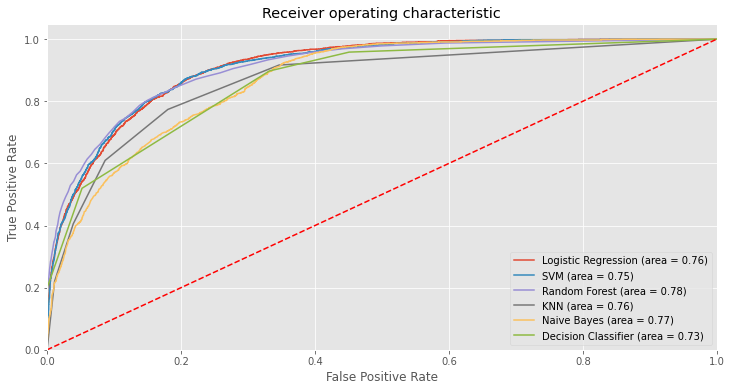

In [47]:
#AUC ROC curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

logit_roc_auc = roc_auc_score(y_test, lr.predict(X_test_scaled))
fpr, tpr, thresholds = roc_curve(y_test, lr.predict_proba(X_test_scaled)[:,1])
fpr2, tpr2, thresholds2 = roc_curve(y_test, svm_clf.decision_function(X_test_scaled))
fpr3, tpr3, thresholds3 = roc_curve(y_test, rfcl.predict_proba(X_test_scaled)[:,1])
fpr4, tpr4, thresholds4 = roc_curve(y_test, clf.predict_proba(X_test_scaled)[:,1])
fpr5, tpr5, thresholds5 = roc_curve(y_test, bern.predict_proba(X_test_scaled)[:,1])
fpr6, tpr6, thresholds6 = roc_curve(y_test, dTreeR.predict_proba(X_test_scaled)[:,1])

plt.figure(figsize=(12,6))
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot(fpr2, tpr2, label='SVM (area = %0.2f)' % results_1[1:2]["AUC"])
plt.plot(fpr3, tpr3, label='Random Forest (area = %0.2f)' % results_1[3:4]["AUC"])
plt.plot(fpr4, tpr4, label='KNN (area = %0.2f)' % results_1[5:6]["AUC"])
plt.plot(fpr5, tpr5, label='Naive Bayes (area = %0.2f)' % results_1[4:5]["AUC"])
plt.plot(fpr6, tpr6, label='Decision Classifier (area = %0.2f)' % results_1[2:3]["AUC"])

plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

           

**This table assesses the ability for each of our models to perform with a 0.7 threshold which we found to be the best for all models. Next, we will take our top 2 performing models, Random Forest and Logistic Regression and do a statistical comparison of false positive probability distribution of both models on the test data.**

***Statistical Comparison of the best two models***

In [48]:
import scipy.stats as stats

# Gettint the probability distribution of False positives of the best two models (Random Forest and Logistic Regression) 
predsrf = np.where(rfcl.predict_proba(X_test_scaled)[:,1] > 0.7, 1, 0)
prob_rf=pd.DataFrame({"prediProb":rfcl.predict_proba(X_test_scaled)[:,1], "pred": predsrf, "actual":y_test})

preds = np.where(dTreeR.predict_proba(X_test_scaled)[:,1] > 0.7, 1, 0)
prob_df=pd.DataFrame({"prediProb":lr.predict_proba(X_test_scaled)[:,1], "pred": preds, "actual":y_test})

tpRf=prob_rf[(prob_df["actual"]==0) & (prob_df["pred"]==1)]["prediProb"]
tplr=prob_df[(prob_df["actual"]==0) & (prob_df["pred"]==1)]["prediProb"]


In [49]:
# Mean is around the same so we can proceed with t-test
print(np.mean(tpRf),np.mean(tplr))

0.925 0.9028168006857865


In [50]:
from statsmodels.stats.weightstats import ttest_ind
import numpy as np
import pingouin as pg

# Goal: RandomForest<LogisticRegression
#If the False positive probability distribution of Random Forest is less than False positive probability distribution of Logistic Regression
# Hypothesis:
# Null : Mean RF >= mean LR
# Alternative : Mean RF < Mean LR

pg.ttest(tpRf, tplr,alternative='less')


,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,0.311457,6,less,0.617004,"[-inf, 0.16]",0.220233,0.928,0.027187


###### There is not enough evidence to suggest that the mean of the probability distribution of false positives of Random Forest is less than the mean of the probability distribution of false positives of Logistic Regression (p_val=0.61). We are 95% confident that the mean of the probability distribution of false positives lies between negative infinity to 0.16.

# Modeling and Evaluation: Part 5


#### Choosing the best model:
+ Highest Accuracy: Random Forest
+ Highest Recall: Naive Bayes Bernoulli
+ Highest Precision: Decision Classifier
+ Highest F-Measure: Naive Bayes
+ Highest AUC: Random Forest

#### As we care the most about Precision, we will choose the Random Forest model for our analysis. We can also see that the Random Forest model also has  a higher F-measure and AUC.

+ Age, education.num, capital.gain, married-civ, and hours per week consistently were the top feature in our different models. These attribues are intuitive because reguardless of the job, someone that is older, works more, and has more experience will have a higher income. Also those in our dataset that reported capital gains will have an increased income from those gains. Interestingly married-civ seems to consistenly show up which could be because a married civilian family would likely have stability and support.

+ Capital gains will increase income while capital loss might bring their overall income below 50K, that could explain why capital loss is not as influential. Considering the real world trend that men make more money than women, it makes sense that relationship_husband would influence making greater than 50K more so than relationship_wife which we see is not as influential.
    
+ There are a lot of occupations that do not seem to be as influental for income such as local gov, which makes sense since these occupations make less money making them less influential. The non profits and people that don't work of course don't make more than 50K making them not helpful at predicting, true positive, people earning greater than 50K.


# Modeling and Evaluation: Part 6

#### Naive Bayes:

Pros: 
+ As long as the assumption of independence between predictors is true Naive Bayes will perform better than most any other model
+ It requires a smaller amount of training data compared to other models to estimate the test data accurately.
+ Naive Bayes is easy to implement

Cons:
+ The main limitation of Naive Bayes is when the assumption of independence for predictors is broken. In real life, very often we cannot get a set of predictors that are completely independent. 
+ It is possible to have a level of a categorical variable not represented in the training data but is represented in the test data. The model will not be able to make a prediction with this specific factor. It is important to make sure each of our factor levels are represented in the training and test data sets. 

#### Decision tree:

Pros:
+ They do not need a lot of data pre-processing
+ They do not require normalization or scaling of the data.
+ They can handle missing values better than a lot of other models.
+ Decision trees are intuitive and easy to explain to many different people with different backgrounds.

Cons:
+ Small changes in the data can cause large changes in the overall structer of the decision tree.
+ Some decision trees can have very complex calculations compared to other algorithms.
+ Training a decision tree model is often longer and more expensive especially when taking into account the complexity of the tree.
+ We cannot apply regression and make predictions for continuous values using the decision tree algorithm.

#### Random Forest

Pros:
+ Random forest reduces overfitting often seen in decision trees to help to improve accuracy.
+ It is flexible when applying to both classification and regression problems
+ It performs well when working with both categorical and continuous values and automatically deals with missing values in the data.
+ It does not require normalization of data because it uses a rule-based approach.

Cons:
+ It requires a lot of computational power and storage because it builds numerous trees to and combines their outputs. 
+ It also requires a lot of time for training due to the large number of trees it will build and combine.
+ Sometimes it is difficult to interperate and we cannot determine the significance of each variable in the model. 

#### K-Nearest Neighbor (KNN)

Pros:
+ It can have quick calculation time
+ It is a simple algorithm to interperate and explain
+ KNN is versatile and can be used for regression and classification
+ Highly accurate even when you compare with more closely supervised models. 
+ KNN does not make any assumptions about the data or need to tune parameters other than the value of K

Cons:
+ As with many models, the accuracy depends on the quality of the datat that is gathered
+ Making predictions on large data can take a long time as every datapoint is used for each caluculation
+ Scaling is very important in KNN. If data are not scaled the results will not be accurate.
+ It is computationally intensive and also requires the use of a lot of memory to store the training data

#### Logistic Regression

Pros:
+ Easy to implement, interprete, and effecient to train.
+ It can easliy be used on mupliple classes (multiple logisic regression).
+ Provides predicition probabilities and a threshold that can be adjusted to make the model more accurate. 
+ It has high accuracy and perfomrs best when the data is able to be separated linearly. 
+ Coefficients are easy to interperate to asses their importance in the model
+ Less likely to overfit but we need to be careful when using high dimensional datasets

Cons:
+ A main limitation of logistic regression is the assumption of linearity between the explanitory variables and the response varaibles. It wants to consructs a linear boundary and sometimes that does not fit our data well
+ Specifically, logistic regression has the assumption that the independent variables are linearly related to the log odds.
+ It is only used to predict discrete outputs. Our response is normally binary or at least has a limited number of possible outcomes.
+ An assumption that often times has a hard time holding up in the real world is that there is no multicolinearity between the independent variables.
+ It can be difficult to understand complex relationships and often neural networks can easily outperform this model

#### SVM

Pros:
+ It gives a clear visualization of the separation between data points with a well defined margin of separation. 
+ SVM is very effecient when working in high dimensional spaces even if they are difficult to visualize.
+ It uses memory effeciently because it only uses a subset of the training points in the decision function (the support vectors)

Cons:
+ It struggles computationally when working with large data because it has a longer training time
+ It is susceptable to a lot of noise and outliers can drastically change the support vectors.
+ It does not provide probability estimates on its own but they can be obtained using cross validation.

# Deployment

Our model would be very helpful for kids growing up in the world today and could be used by teachers to educate their students on the factors that help you make more money in today's society. It is important to know which factors you cannot change that are working against you in our society so you can focus on factors that you can change to give yourself a better life. As our model focuses on precision, we care the most about which positive results (people making >50K) are actually positive. So by this definition, we will focus on factors that really are helping or influencing someone make >50K. This kind of model would be perfect for schools to be able to educate their kids so they can make life choices that will benefit themselves the most in the future.

We could measure the value of this model by taking census data for kids that were both exposed to this information and not exposed to this information. After a specified amount of time we could see how many from each groups are making >50K. Out of those making >50K, how many fall in categoreies that have factors that are working against them in society and have they been able to break away from those trends.

We could collect more data on different age distribution, years of work experience and work status (contractor versus salary). This might give us more insights and improve the model. 

This model would need to be updated due to population drift from age, gender and societal distribution. However, it could wait 5 to 10 years because many jobs that are lucrative do not change very much over time. Also, politics does not change very quickly so any societal issues that are making it difficult for certain groups of people to make >50K would not change very quickly. If there are any world events like a war or a pandemic then the model would have to be retrained sooner.


